# Comparison of sequential minimization strategies

Run the sequential minimization of the 10-parameter ansatz over the local and global cost functions with the fit method for the cost function sections.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit, transpile

sys.path.append('..')
from cost_sections import FitSecond, FitFirst, FitGeneral, FitSymmetric
from pnp_ansatze import make_pnp_ansatz
from cost_functions import global_cost_function, local_cost_function
from sequential_minimizer import SequentialVCMinimizer
from rttgen import CNOTBasedRtt
from cx_decomposition import cx_circuit
from model_circuits import single_step, two_steps

In [2]:
num_sites = 4
aJ = 1.
am = 0.5
omegadt = 0.2
# aJ = 0.7
# am = 0.439
# omegadt = 0.167
num_tstep = 6

backend = Aer.get_backend('statevector_simulator')
physical_qubits = None

In [3]:
def make_compiler_circuit():
    qubit_pairs = list(zip(range(0, num_sites - 1), range(1, num_sites)))

    rtts = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in qubit_pairs)
    cxs = dict((qubits, cx_circuit(backend, *qubits)) for qubits in qubit_pairs)
    cxs.update((qubits[::-1], cx_circuit(backend, *qubits[::-1])) for qubits in qubit_pairs)

    two_step_circuit = two_steps(num_sites, aJ, am, omegadt, rtts=rtts, cxs=cxs)

    target_circuit = QuantumCircuit(num_sites)
    target_circuit.x([0, 2])
    target_circuit.compose(two_step_circuit, inplace=True)

    uncomputer = make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[1, 2], structure=[(1, 2), (0, 1), (2, 3)], first_layer_structure=[(0, 1), (2, 3)]).inverse()

    return target_circuit.compose(uncomputer)

In [4]:
def make_minimizer(compiler_circuit, cost_function, strategy):
    minimizer = SequentialVCMinimizer(compiler_circuit, cost_function, backend, strategy=strategy, shots=4096, default_section=FitGeneral)
    minimizer.cost_section_generators[0] = FitSecond
    minimizer.cost_section_generators[1] = FitFirst
    minimizer.cost_section_generators[2] = FitSecond
    minimizer.cost_section_generators[3] = FitFirst
    minimizer.cost_section_generators[5] = FitFirst
    
    return minimizer

In [5]:
def callback_step(minimizer, arg):
    print('isweep', arg['isweep'], 'iparam', arg['iparam'], 'cost', arg['cost_section'].fun(arg['theta_opt']), 'total shots', arg['current_shots'] + arg['step_shots'])
    
def callback_sweep(minimizer, arg):
    print('isweep', arg['isweep'], 'update distance', np.max(np.abs(arg['current_param_val'] - arg['sweep_param_val'])), 'cost', arg['sweep_cost'], 'cost update', arg['sweep_cost'] - arg['current_cost'], 'total shots', arg['current_shots'] + arg['sweep_shots'])
    print('params [' + ', '.join(map(str, arg['sweep_param_val'])) + ']')
    
def switch_to_gradient_descent(minimizer, arg):
    print('Switching to gradient descent at cost', arg['sweep_cost'])
    minimizer.strategy = 'gradient-descent'
    if SequentialVCMinimizer.ideal_cost_step in minimizer.callbacks_step:
        minimizer.callbacks_step.remove(SequentialVCMinimizer.ideal_cost_step)
    if SequentialVCMinimizer.ideal_cost_sweep not in minimizer.callbacks_sweep:
        minimizer.callbacks_sweep.append(SequentialVCMinimizer.ideal_cost_sweep)
        
def switch_to_gradient_descent_by_absolute_cost(minimizer, arg):
    if minimizer.strategy != 'gradient-descent' and arg['sweep_cost'] < 0.02:
        switch_to_gradient_descent(minimizer, arg)

def switch_to_gradient_descent_by_cost_update(minimizer, arg):
    cost_update = arg['sweep_cost'] - arg['current_cost']
    if minimizer.strategy != 'gradient-descent' and cost_update < 0. and cost_update > -0.1:
        switch_to_gradient_descent(minimizer, arg)
        
class SwitchToSymmetric:
    def __init__(self, threshold, param_ids):
        self.threshold = threshold
        self.param_ids = list(param_ids)
        self.section_gen_switched = False
        
    def callback(self, minimizer, arg):
        if self.section_gen_switched:
            return
        
        if arg['sweep_cost'] < self.threshold:
            for iparam in self.param_ids:
                minimizer.cost_section_generators[iparam] = FitSymmetric
                
            self.section_gen_switched = True

In [6]:
import multiprocessing

def run_minimizer(cost_type, strategy, queue):
    if cost_type == 'local':
        cost_function = local_cost_function
    else:
        cost_function = global_cost_function
        
    switch_to_symmetric = SwitchToSymmetric(0.015, [4, 6, 7, 8, 9])
        
    compiler_circuit = make_compiler_circuit()
    
    minimizer = make_minimizer(compiler_circuit, cost_function, strategy.replace('_gradient-descent', ''))
    
    if 'sequential' in strategy:
        minimizer.callbacks_step.append(SequentialVCMinimizer.ideal_cost_step)
    else:
        minimizer.callbacks_sweep.append(SequentialVCMinimizer.ideal_cost_sweep)
        
    if '_gradient-descent' in strategy:
        minimizer.callbacks_sweep.append(switch_to_gradient_descent_by_cost_update)
    
    minimizer.callbacks_sweep.append(switch_to_symmetric.callback)
    
    initial_param_val = np.ones(len(compiler_circuit.parameters), dtype='f8') * np.pi / 4.
    param_val, total_shots = minimizer.minimize(initial_param_val)
    
    if 'sequential' in strategy:
        shots_values = np.array(minimizer.shots_step)
        cost_values = np.array(minimizer.ideal_costs_step)
        if strategy == 'sequential_gradient-descent':
            shots_values = np.concatenate((shots_values, minimizer.shots_sweep))
            cost_values = np.concatenate((cost_values, minimizer.ideal_costs_sweep))
    else:
        shots_values = np.array(minimizer.shots_sweep)
        cost_values = np.array(minimizer.ideal_costs_sweep)
    
    queue.put((cost_type, strategy, param_val, shots_values, cost_values))
    
def driver():
    procs = dict()
    queue = multiprocessing.Queue()
    for cost_type in ['local', 'global']:
        for strategy in ['sequential', 'sequential_gradient-descent', 'largest-drop', 'largest-drop_gradient-descent']:
            proc = multiprocessing.Process(target=run_minimizer, args=(cost_type, strategy, queue))
            proc.start()
            procs[(cost_type, strategy)] = proc
            
    results = dict()
        
    while len(procs) != 0:
        cost_type, strategy, param_val, shots_values, cost_values = queue.get()
        print('{} {} returned'.format(cost_type, strategy))
        procs.pop((cost_type, strategy)).join()
        results[(cost_type, strategy)] = (param_val, shots_values, cost_values)
        
    return results    

In [7]:
results = driver()

Switching to gradient descent at cost 0.0036746528487660024
Switching to gradient descent at cost 0.00026555025728070003
Switching to gradient descent at cost 0.129311880336609
SMO converged by cost update
global sequential_gradient-descent returned
SMO converged by cost update
global sequential returned
Switching to gradient descent at cost 0.051398373048535784


/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


SMO converged by cost update
local sequential_gradient-descent returned


/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


SMO converged by cost update
local sequential returned
SMO converged by cost update
local largest-drop returned
SMO converged by cost update
global largest-drop_gradient-descent returned


/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


SMO converged by cost update
local largest-drop_gradient-descent returned
SMO converged by parameter distance
global largest-drop returned


## Strategy comparison

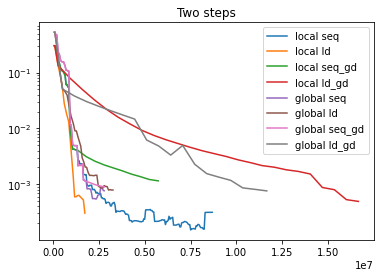

In [8]:
res = results[('local', 'sequential')]
plt.plot(res[1], res[2], label='local seq')
res = results[('local', 'largest-drop')]
plt.plot(res[1], res[2], label='local ld')
res = results[('local', 'sequential_gradient-descent')]
plt.plot(res[1], res[2], label='local seq_gd')
res = results[('local', 'largest-drop_gradient-descent')]
plt.plot(res[1], res[2], label='local ld_gd')
res = results[('global', 'sequential')]
plt.plot(res[1], res[2], label='global seq')
res = results[('global', 'largest-drop')]
plt.plot(res[1], res[2], label='global ld')
res = results[('global', 'sequential_gradient-descent')]
plt.plot(res[1], res[2], label='global seq_gd')
res = results[('global', 'largest-drop_gradient-descent')]
plt.plot(res[1], res[2], label='global ld_gd')
plt.yscale('log')
plt.legend()
plt.title('Two steps');

## Result validation

Largest-drop with local cost function converged the fastest for two Trotter steps. Are the resulting parameter values good enough? Check with RQD.

In [10]:
qubit_pairs = list(zip(range(0, num_sites - 1), range(1, num_sites)))

rtts = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in qubit_pairs)
cxs = dict((qubits, cx_circuit(backend, *qubits)) for qubits in qubit_pairs)
cxs.update((qubits[::-1], cx_circuit(backend, *qubits[::-1])) for qubits in qubit_pairs)
two_step_circuit = two_steps(num_sites, aJ, am, omegadt, rtts=rtts, cxs=cxs)

forward_circuit = make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[1, 2], structure=[(1, 2), (0, 1), (2, 3)], first_layer_structure=[(0, 1), (2, 3)])
forward_circuit.compose(two_step_circuit, inplace=True)

param_dict = dict(zip(forward_circuit.parameters, results[('local', 'largest-drop')][0]))
approx_statevector = backend.run(transpile(forward_circuit.assign_parameters(param_dict), backend=backend)).result().results[0].data.statevector

true_circuit = QuantumCircuit(num_sites)
true_circuit.x([0, 2])
true_circuit.compose(two_step_circuit, inplace=True)
true_circuit.compose(two_step_circuit, inplace=True)

true_statevector = backend.run(transpile(true_circuit, backend=backend)).result().results[0].data.statevector

print(np.square(np.abs(approx_statevector.conjugate() @ true_statevector)))

0.9991256652408679


In [11]:
print(results[('local', 'largest-drop')][0])

[5.88840611 0.76283482 1.53601305 0.0330668  1.22698455 2.32726878
 0.78539816 0.93775626 1.1851489  1.07022145]
